## _Inference after GNN Stage_

**_Inference_** is done using callbacks defined in the **_LightningModules/GNN/Models/inference.py_**. The callbacks run during the **_test_step()_** _a.k.a_ model _**evalution**_.

### How to run _Inference_?

1. _`traintrack config/pipeline_quickstart.yaml`_. One can use `--inference` flag to run only the test_step() (Should work, but failed.)
2. _`infer.ipynb`_ notebook runs the _pl.Trainer().test()_

In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
from tqdm import tqdm
import trackml.dataset

In [4]:
import torch
import pytorch_lightning as pl
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import itertools

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
os.environ['EXATRKX_DATA'] = os.path.abspath(os.curdir)

In [7]:
from LightningModules.GNN import InteractionGNN
from LightningModules.GNN import GNNMetrics

In [8]:
from LightningModules.GNN.Models.infer import GNNTelemetry

## _Classifier Evaluation_

Metrics to evaluate the GNN networks:

- Accuracy/ACC = $TP+TN/TP+TN+FP+FN$
- sensitivity, recall, hit rate, or true positive rate ($TPR = 1 - FNR$)
- specificity, selectivity or true negative rate ($TNR = 1 - FPR$)
- miss rate or false negative rate ($FNR = 1 - TPR$)
- fall-out or false positive rate ($FPR = 1 - TNR$)
- F1-score = $2 \times (\text{PPV} \times \text{TPR})/(\text{PPV} + \text{TPR})$
- Efficiency/Recall/Sensitivity/Hit Rate: $TPR = TP/(TP+FN)$
- Purity/Precision/Positive Predictive Value: $PPV = TP/(TP+FP$
- AUC-ROC Curve $\equiv$ FPR ($x-$axis) v.s. TPR ($y-$axis) plot
- AUC-PRC Curve $\equiv$ TPR ($x-$axis) v.s. PPV ($y-$axis) plot

### _Load Config_

In [9]:
# load processing config file (trusted source)
config = None
config_file = os.path.join(os.curdir, 'LightningModules/GNN/configs/train_alldata_GNN.yaml')
with open(config_file) as f:
    try:
        config = yaml.load(f, Loader=yaml.FullLoader) # equiv: yaml.full_load(f)
    except yaml.YAMLError as e:
        print(e)

In [10]:
# print(config)

### _Test Dataset_

In [11]:
# Test Dataset from GNNBuilder
inputdir="run/gnn_processed/test"
all_events = sorted(glob.glob(os.path.join(inputdir, "*")))

In [12]:
# Load Single Event
test_event = torch.load(all_events[0], map_location=device)

### _Load Model Checkpoint_

- Load model checkpoint
- Load saved config file

In [13]:
# Load Model Checkpoint
ckpnt_path = "run/lightning_models/lightning_checkpoints/GNNStudy/version_1/checkpoints/last.ckpt"
checkpoint = torch.load(ckpnt_path, map_location=device)
config = checkpoint["hyper_parameters"]

In [14]:
# Load Model Checkpoint
checkpoint = torch.load(ckpnt_path, map_location=device)

In [15]:
# View Hyperparameters
# print(config)

In [16]:
# One Can Modify Hyperparameters
config["checkpoint_path"] = ckpnt_path
config["input_dir"] = "run/feature_store"
config["output_dir"] = "run/gnn_processed"
config["artifact_library"] = "lightning_models/lightning_checkpoints"
config["datatype_split"] = [0, 0, 5000]
config["map_location"] = device

In [17]:
# View Hyperparameters (New)
# print(config)

In [18]:
# Init InteractionGNN with New Config
model = InteractionGNN(config)

In [19]:
# Load Checkpoint with New Config
model = model.load_from_checkpoint(**config)

In [20]:
# Init Lightning Trainer
trainer = pl.Trainer(callbacks=[GNNTelemetry()])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Loading data to 'cpu'
Trainset: 0, Valset: 0, Testset: 5000



Testing: 0it [00:00, ?it/s]

/shared/adeel/anaconda3/envs/exatrkx-cpu/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
preds: torch.Size([7778030]), truth: torch.Size([7778030])


[{}]

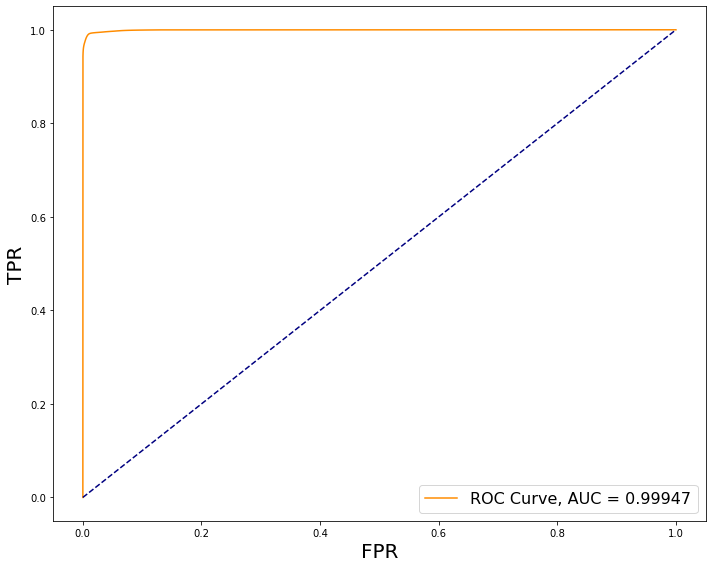

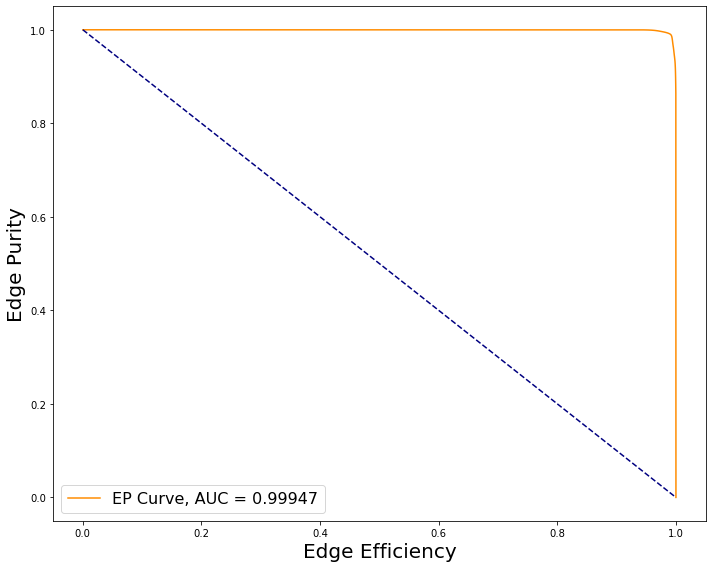

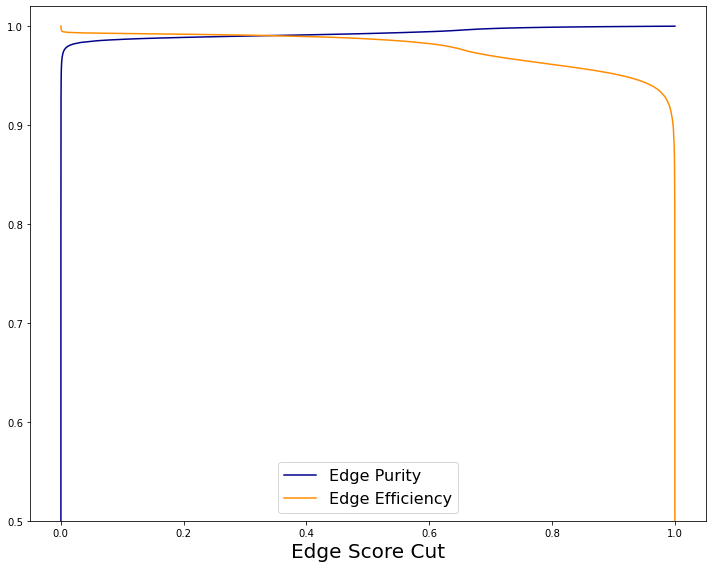

In [21]:
# Run Test Loop
trainer.test(model=model, dataloaders=None, ckpt_path=None, verbose=True, datamodule=None)

### _Test with LightningDataModule_

In [22]:
from LightningModules.GNN.utils.data_utils import split_datasets, load_dataset

In [23]:
class SttDataModule(pl.LightningDataModule):
    def __init__(self, hparams):
        super().__init__()

        # Set workers from hparams
        self.n_workers = (
            self.hparams["n_workers"]
            if "n_workers" in self.hparams
            else len(os.sched_getaffinity(0))
        )

        # Instance Variables
        self.train_split = self.hparams["train_split"]
        self.trainset, self.valset, self.testset = None, None, None

    def setup(self, stage: str):

        if stage == "fit":
            self.trainset, self.valset, self.testset = split_datasets(**self.hparams)

        if stage == "test":
            print("Number of Test Events: ", self.hparams["train_split"][2])
            self.testset = load_dataset(self.hparams["input_dir"], self.train_split[2])

    def train_dataloader(self):
        if self.trainset is not None:
            return DataLoader(
                self.trainset, batch_size=1, num_workers=self.n_workers
            )  # , pin_memory=True, persistent_workers=True)
        else:
            return None

    def val_dataloader(self):
        if self.valset is not None:
            return DataLoader(
                self.valset, batch_size=1, num_workers=self.n_workers
            )  # , pin_memory=True, persistent_workers=True)
        else:
            return None

    def test_dataloader(self):
        if self.testset is not None:
            return DataLoader(
                self.testset, batch_size=1, num_workers=self.n_workers
            )  # , pin_memory=True, persistent_workers=True)
        else:
            return None

In [24]:
# Prepare LightningDataModule (Error)
# dm = SttDataModule(config)

In [25]:
# dm.setup(stage='test')

In [26]:
# test_dataloaders = dm.test_dataloader

In [27]:
# trainer.test(model=model, dataloaders=None, ckpt_path=None, verbose=True, datamodule=dm)

### _TensorBoard Logger_

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=run_all/lightning_models/lightning_checkpoints/GNNStudy